In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl

## Read all files into a dataframe

In [42]:
# patient_df = []
# features = None

# for file in os.listdir('sepsis_data/'):

#     with open('sepsis_data/%s' % (file)) as f:
        
#         if not features:
#             features = f.readline().rstrip('\n').split('|')
#         else:
#             # This skips the headers
#             f.readline()
        
#         for idx, line in enumerate(f):
#             # Append patient ID and time to beginning of data vector
#             pdata = [file.split('.')[0]]
#             pdata.append(idx + 1)
            
#             line = line.rstrip('\n')
#             pdata.extend(line.split('|'))
#             patient_df.append(pdata)

In [105]:
# patient_df = pd.DataFrame(patient_df, columns=['pid', 'time'] + features)
# patient_df.to_csv('patient_df')

patient_df = pd.read_csv('patient_df').drop(columns='Unnamed: 0')

In [74]:
patient_df.shape

(188453, 43)

In [53]:
patient_df.head()

,pid,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,p01065,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,54,1,1.0,0.0,-5.76,1,0
1,p01065,2,83.0,100.0,NaN,103.0,68.0,58.0,NaN,NaN,...,NaN,NaN,NaN,54,1,1.0,0.0,-5.76,2,0
2,p01065,3,80.0,99.0,36.7,103.0,69.0,58.0,10.0,NaN,...,NaN,NaN,NaN,54,1,1.0,0.0,-5.76,3,0
3,p01065,4,87.0,99.0,NaN,107.0,76.0,67.0,NaN,NaN,...,NaN,NaN,NaN,54,1,1.0,0.0,-5.76,4,0
4,p01065,5,91.0,99.0,NaN,106.0,76.0,68.0,NaN,NaN,...,NaN,NaN,NaN,54,1,1.0,0.0,-5.76,5,0


In [73]:
np.sum(patient_df.time == patient_df.ICULOS)

177324

## Exploratory Analysis

### 1. Figure out number of patients with sepsis 

In [54]:
patient_df[patient_df.SepsisLabel == 1]['pid'].unique().shape

(279,)

### 2. Number of Septic patients between Units

In [64]:
patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Unit1 == 1)]['pid'].unique().shape

(88,)

Unit 1: 88 septic patients 

Unit 2: 191 septic patients

### Male Female Ratio

In [65]:
patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Gender == 0)]['pid'].unique().shape

(122,)

In [66]:
patient_df[(patient_df.Gender == 0)]['pid'].unique().shape

(2295,)

### Age Range of Septic Patients

In [69]:
ages = patient_df[(patient_df.SepsisLabel == 1)]['Age'].unique()

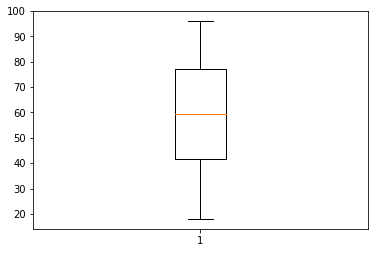

In [70]:
plt.boxplot(ages)
plt.show()

### Let's try simple Logistic Regression on Aggregated Data

In [114]:
dataset = patient_df.drop(columns=['Age', 'Gender', 'Unit1', 'Unit2', 'ICULOS', 'time', 'HospAdmTime'])

In [120]:
# Create min() mean() and max() features for each patient
y = dataset.groupby(by=['pid']).agg(['max'])['SepsisLabel']
X = dataset.drop(columns=['SepsisLabel']).groupby(by=['pid']).agg(['min', 'mean', 'max'])

In [123]:
# Replace NaN with 0
X = X.fillna(value=0)

In [132]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [133]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model = model.fit(X_train, y_train)

/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [135]:
y_pred = model.predict_proba(X_test)

In [139]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred[:,1])

0.7748534173448849